<a href="https://colab.research.google.com/github/plodha/CMPE-297-DeepLearning/blob/main/Notebook/AnoGAN_Inference_Metric_AllCat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount Drive and Set Environment

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install torch==1.4.0 torchvision==0.5.0 tqdm opencv-python Pillow==8.0.1 tensorboardX==1.4

     |████████████████████████████████| 753.4MB 20kB/s 


In [ ]:
!nvidia-smi

In [ ]:
!ls

In [ ]:
import argparse
import os
import numpy as np
import math
import sys
import random
import pandas as pd
#import torchvision.transforms as transforms
from torchvision.utils import save_image
#from dataloader.dataloader import load_data
#from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable
#from networks import Generator, Discriminator
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

import torch
import cv2
ngpu = 1
os.makedirs("images", exist_ok=True)

In [ ]:
from torch.utils.data import DataLoader, Dataset
class MURA_dataset(Dataset):
    '''
    Dataset class for MURA dataset
    Args:
        - df: Dataframe with the first columns contains the path to the images
        - root_dir: string contains path of  root directory
        - transforms: Pytorch transform operations
    '''

    def __init__(self, df, root_dir, transforms=None):
        #print("I am calling Mura dataset")
        self.df = df
        self.root_dir = root_dir
        self.transforms = transforms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.df.iloc[idx, 0])
        #print('img_name ',img_name)
        img = cv2.imread(img_name)
        #print('img shape ',img.shape)

        if self.transforms:
            img = self.transforms(img)

        if 'negative' in img_name: label = 0
        else: label = 1

        return img, label

In [ ]:
def transform(rotation, hflip, resize, totensor, normalize, centercrop, to_pil, gray):
    options = []
    if to_pil:
        options.append(torchvision.transforms.ToPILImage())
    if gray:
        options.append(torchvision.transforms.Grayscale())
    if rotation:
        options.append(torchvision.transforms.RandomRotation(20))
    if hflip:
        options.append(torchvision.transforms.RandomHorizontalFlip())
    if centercrop:
        options.append(torchvision.transforms.CenterCrop(256))
    if resize:
        options.append(torchvision.transforms.Resize((32,32)))
    if totensor:
        options.append(torchvision.transforms.ToTensor())
    # if True:
    #     options.append(transforms.Lambda(lambda x: (x - x.min())/(x.max()-x.min())))
    if normalize:
        options.append(torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)))
    transform = torchvision.transforms.Compose(options)
    return transform

In [ ]:
def customDf(path, studyClass=None, studyType=None):
    '''
    Function to get custom csv based on class of study and type of study
    Args:
        - path(string): path to original csv
        - studyClass(list): class of study, list must contains one of the following:
            "XR_ELBOW",
            "XR_FINGER",
            "XR_FOREARM",
            "XR_HAND",
            "XR_HUMERUS",
            "XR_SHOULDER",
            "XR_WRIST"
            if None, take all
        - studyResult(list): Result of study, list must contains one of the following:
            "positive", "negative"
            if None, take all
    '''
    df = pd.read_csv(path, header=None)

    if studyClass:
        cond = df[0].str.contains(studyClass)
        df = df[cond]
    if studyType:
        cond = df[0].str.contains(studyType)
        df = df[cond]
    return df

In [ ]:
#import pandas as pd
#import torchvision
#transforms = transform(False, True, True, True, True, True, True, False)
#transforms = transform(False, True, True, True, True, True, True, False)


#mura_valid_df = customDf('../datasets/MURA-v1.1/valid_image_paths.csv', 'XR_HUMERUS', None)
#valid_dataset = MURA_dataset(mura_valid_df, '../datasets/', transforms)

In [ ]:
#valid_dataloader = torch.utils.data.DataLoader(dataset=valid_dataset,batch_size=64,shuffle=True,num_workers=4,drop_last=False)

In [ ]:
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print(device)

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Generator

In [ ]:
class Generator(nn.Module):
    def __init__(self, dim, zdim, nc):
        super(Generator, self).__init__()
        self.nc = nc
        self.dim = dim
        preprocess = nn.Sequential(
            nn.Linear(zdim, 4 * 4 * 4 * dim),
            nn.BatchNorm1d(4 * 4 * 4 * dim),
            nn.ReLU(True),
        )

        block1 = nn.Sequential(
            nn.ConvTranspose2d(4 * dim, 2 * dim, 2, stride=2),
            nn.BatchNorm2d(2 * dim),
            nn.ReLU(True),
        )
        block2 = nn.Sequential(
            nn.ConvTranspose2d(2 * dim, dim, 2, stride=2),
            nn.BatchNorm2d(dim),
            nn.ReLU(True),
        )
        deconv_out = nn.ConvTranspose2d(dim, nc, 2, stride=2)

        self.preprocess = preprocess
        self.block1 = block1
        self.block2 = block2
        self.deconv_out = deconv_out
        self.tanh = nn.Tanh()

    def forward(self, input):
        output = self.preprocess(input)
        output = output.view(-1, 4 * self.dim, 4, 4)
        output = self.block1(output)
        output = self.block2(output)
        output = self.deconv_out(output)
        output = self.tanh(output)
        return output.view(-1, self.nc, 32, 32)

# Discriminator

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, dim, zdim, nc, out_feat=False):
        super(Discriminator, self).__init__()
        self.nc = nc
        self.dim = dim
        main = nn.Sequential(
            nn.Conv2d(nc, dim, 3, 2, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(dim, 2 * dim, 3, 2, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(2 * dim, 4 * dim, 3, 2, padding=1),
            nn.LeakyReLU(),
        )
        self.out_feat=out_feat
        self.main = main
        self.linear = nn.Linear(4*4*4*dim, 1)

    def forward(self, input):
        output = self.main(input)
        output = output.view(-1, 4*4*4*self.dim)
        if self.out_feat:
            return output
        output = self.linear(output)
        return output


class Encoder(nn.Module):
     def __init__(self,dim, zdim, nc):
         super(Encoder, self).__init__()
         self.dim = dim
         main = nn.Sequential(
            nn.Conv2d(nc, dim, 3, 2, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(dim, 2 * dim, 3, 2, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(2 * dim, 4 * dim, 3, 2, padding=1),
            nn.LeakyReLU(),
            )
         self.main = main
         self.linear = nn.Linear(4*4*4*dim, zdim)

     def forward(self, input):
         output = self.main(input)
         output = output.view(-1, 4*4*4*self.dim)
         output = self.linear(output)
         return output

# Inference

## Category 
arr = ["XR_ELBOW","XR_FINGER","XR_FOREARM","XR_HAND","XR_HUMERUS","XR_SHOULDER","XR_WRIST"]

In [ ]:
from PIL import Image
import numpy as np

## 1.XR_HUMERUS

In [ ]:
# change the path here to shared drive
import pandas as pd
import torchvision
#transforms = transform(False, True, True, True, True, True, True, False)
transforms = transform(False, True, True, True, True, True, True, False)

#mura_valid_df = customDf('../datasets/MURA-v1.1/valid_image_paths.csv', 'XR_HUMERUS', None)    #scs
#valid_dataset = MURA_dataset(mura_valid_df, '../datasets/', transforms)


mura_valid_df = customDf('/content/drive/Shared drives/MeanSquare-Drive/Advanced-DeepLearning/MURA-v1.1/valid_image_paths.csv', 'XR_HUMERUS', None)
valid_dataset = MURA_dataset(mura_valid_df, '/content/drive/Shared drives/MeanSquare-Drive/Advanced-DeepLearning/', transforms)

FileNotFoundError: ignored

In [ ]:
valid_dataloader = torch.utils.data.DataLoader(dataset=valid_dataset,batch_size=64,shuffle=True,num_workers=4,drop_last=False)

In [ ]:

def tensor2im(input_image, imtype=np.uint8):
    """"Converts a Tensor array into a numpy image array.

    Parameters:
        input_image (tensor) --  the input image tensor array
        imtype (type)        --  the desired type of the converted numpy array
    """
    if not isinstance(input_image, np.ndarray):
        if isinstance(input_image, torch.Tensor):  # get the data from a variable
            image_tensor = input_image.data
        else:
            return input_image
        image_numpy = image_tensor[0].cpu().float().numpy()  # convert it into a numpy array
        if image_numpy.shape[0] == 1:  # grayscale to RGB
            image_numpy = np.tile(image_numpy, (3, 1, 1))
        image_numpy = (np.transpose(image_numpy, (1, 2, 0)) + 1) / 2.0 * 255.0  # post-processing: tranpose and scaling
    else:  # if it is a numpy array, do nothing
        image_numpy = input_image
    return image_numpy.astype(imtype)

(32, 32, 3)
(32, 32, 3)
torch.Size([288])
0.5
0.5
288


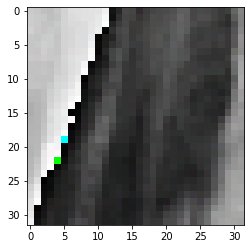

In [ ]:


n_epochs = 5001
batch_size = 64
lr = 0.0002
b1 = 0.5
b2 = 0.999
n_cpu = 8
latent_dim = 128
img_size = 64
channels = 3
sample_interval = 100
abnormal_class = 0
device = 'cuda' 
out = '../anoGAN-ckpts-XR_HUMERUS/'

img_shape = (channels, img_size, img_size)
max_auc = 0


generator = Generator(dim = 64, zdim=latent_dim, nc=channels)
discriminator = Discriminator(dim = 64, zdim=latent_dim, nc=channels,out_feat=True)
encoder = Encoder(dim = 64, zdim=latent_dim, nc=channels)

generator.load_state_dict(torch.load(out+'G_epoch5000.pt'))
discriminator.load_state_dict(torch.load(out+'D_epoch5000.pt'))
generator.to(device)
encoder.to(device)
discriminator.to(device)
with torch.no_grad():
    labels = torch.zeros(size=(len(valid_dataloader.dataset),),
                                        dtype=torch.long, device=device)

    scores = torch.empty(
                size=(len(valid_dataloader.dataset),),
                dtype=torch.float32,
                device=device)
    for i, (imgs, lbls) in enumerate(valid_dataloader):
            imgs = imgs.to(device)
            lbls = lbls.to(device)

            labels[i*batch_size:(i+1)*batch_size].copy_(lbls)
            emb_query = encoder(imgs)
            fake_imgs = generator(emb_query)

            image_feats  = discriminator(imgs)
            recon_feats = discriminator(fake_imgs)
                
            diff = imgs-fake_imgs
            
            image1_tensor= diff[0]
           
            im = tensor2im(imgs)
            plt.imshow(im)
            
            im2 = tensor2im(fake_imgs)
            plt.imshow(im2)
            
            im3 = tensor2im(diff)
            plt.imshow(im3)
            print(im.shape)
            print(im3.shape)
            break   
            
            image_distance = torch.mean(torch.pow(imgs-fake_imgs, 2), dim=[1,2,3])
            feat_distance = torch.mean(torch.pow(image_feats-recon_feats, 2), dim=1)

            # z_distance = mse_loss(emb_query, emb_fake)
            scores[i*batch_size:(i+1)*batch_size].copy_(feat_distance)

    labels = labels.cpu()
    # scores = torch.mean(scores,)
    scores = scores.cpu().squeeze()
    print(scores.shape)
    # True/False Positive Rates.
    fpr, tpr, thresholds = roc_curve(labels, scores)
    roc_auc = auc(fpr, tpr)
    print(roc_auc)
    max_auc = max(roc_auc, max_auc)
    print(max_auc)
    
    print(len(valid_dataloader.dataset))